In [1]:
#This code goes after the 2_Training_Single_Models notebook. It is splitted for the sake of clarity. 
#In order to make it functional just paste it after the previous notebook

In [ ]:
#Code adapted from https://github.com/morganmcg1/gradient_blending/blob/master/Gradient_Blending_Melanoma.ipynb

## Join Model

In [99]:
from fastai.data.load import _FakeLoader, _loaders

In [100]:
class MixedDL():
    def __init__(self, tab_dl:TabDataLoader, vis_dl:TfmdDL, device='cuda:3'):
        "Stores away `tab_dl` and `vis_dl`, and overrides `shuffle_fn`"
        self.device = device
        tab_dl.shuffle_fn = self.shuffle_fn
        vis_dl.shuffle_fn = self.shuffle_fn
        self.dls = [tab_dl, vis_dl]
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0)
    
    def __len__(self): return len(self.dls[0])
        
    def shuffle_fn(self, idxs):
        "Generates a new `rng` based upon which `DataLoader` is called"
        if self.count == 0: # if we haven't generated an rng yet
            self.rng = self.dls[0].rng.sample(idxs, len(idxs))
            self.count += 1
            return self.rng
        else:
            self.count = 0
            return self.rng
        
    def to(self, device): self.device = device

In [101]:
@patch
def __iter__(dl:MixedDL):
    "Iterate over your `DataLoader`"
    z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in dl.dls])
    for b in z:
        if dl.device is not None: 
            b = to_device(b, dl.device)
        batch = []
        batch.extend(dl.dls[0].after_batch(b[0])[:2])
        batch.append(dl.dls[1].after_batch(b[1][0]))
        try: # In case the data is unlabelled
            batch.append(b[1][1])
            yield tuple(batch)
        except:
            yield tuple(batch)

In [102]:
@patch
def one_batch(x:MixedDL):
    "Grab a batch from the `DataLoader`"
    with x.fake_l.no_multiproc(): res = first(x)
    if hasattr(x, 'it'): delattr(x, 'it')
    return res

In [103]:
@patch
def show_batch(x:MixedDL):
    "Show a batch from multiple `DataLoaders`"
    for dl in x.dls:
        dl.show_batch()

In [104]:
train_mixed_dl_0 = MixedDL(tab_dl_0[0], vis_dl_0[0])
valid_mixed_dl_0 = MixedDL(tab_dl_0[1], vis_dl_0[1])
#test_mixed_dl_0 = MixedDL(tab_dl_0[2], vis_dl_0[2])
mixed_dls_0 = DataLoaders(train_mixed_dl_0, valid_mixed_dl_0).cuda()

train_mixed_dl_1 = MixedDL(tab_dl_1[0], vis_dl_1[0])
valid_mixed_dl_1 = MixedDL(tab_dl_1[1], vis_dl_1[1])
mixed_dls_1 = DataLoaders(train_mixed_dl_1, valid_mixed_dl_1).cuda()

train_mixed_dl_2 = MixedDL(tab_dl_2[0], vis_dl_2[0])
valid_mixed_dl_2 = MixedDL(tab_dl_2[1], vis_dl_2[1])
mixed_dls_2 = DataLoaders(train_mixed_dl_2, valid_mixed_dl_2).cuda()

train_mixed_dl_3 = MixedDL(tab_dl_3[0], vis_dl_3[0])
valid_mixed_dl_3 = MixedDL(tab_dl_3[1], vis_dl_3[1])
mixed_dls_3 = DataLoaders(train_mixed_dl_3, valid_mixed_dl_3).cuda()

train_mixed_dl_4 = MixedDL(tab_dl_4[0], vis_dl_4[0])
valid_mixed_dl_4 = MixedDL(tab_dl_4[1], vis_dl_4[1])
mixed_dls_4 = DataLoaders(train_mixed_dl_4, valid_mixed_dl_4).cuda()

In [ ]:
test_mixed_dl_0 = MixedDL(tab_dl_0[2], vis_dl_0[2])

,Sexe,PLAQUETES_na,RDW-CV_na,RDW-SD_na,V._P._M._na,BASFILS,BASFILS_T,EOSINFILS_T,H._C._M.,HEMATIES,HEMOGLOBINA,LEUCCITS,LIMFCITS_T,M._C._H._C.,MONCITS,MONCITS_T,NEUTRFILS,NEUTRFILS_T,PLAQUETES,RDW-CV,RDW-SD,V._C._M.,V._P._M.,Label
0,H,False,False,False,False,-0.529905,-0.042619,-1.764419,0.327296,0.069237,0.256103,1.086560,-0.401037,2.023501,-1.015581,0.177863,1.283125,1.247051,0.981882,-1.260162,-2.064890,-0.833730,-1.142368,Control
1,M,False,False,False,False,-0.113153,0.140176,0.959306,1.062829,0.477542,1.075995,0.191191,1.109361,-0.106719,0.115586,0.269114,-0.735738,-0.061863,0.665941,-0.263169,0.311512,1.308707,-1.083992,Heart_failure
2,H,False,False,False,False,1.014403,0.308369,0.648938,0.368466,1.291433,1.589538,-0.957729,0.754033,0.356621,1.759779,0.442429,-1.736971,-1.446346,-0.650847,-0.652850,-0.395516,0.207904,-1.083992,Control
3,H,False,False,False,False,-0.113153,-0.596313,-0.172754,0.409741,-1.020060,-0.862218,-0.778931,-0.210466,0.801007,1.094833,0.204271,-0.316617,-0.662428,0.394905,0.770717,0.738793,-0.014949,-0.218763,Control
4,M,False,False,False,False,-0.113153,-0.042619,0.789199,-0.038514,-0.169038,-0.147154,0.232224,1.537539,0.025927,-0.512259,-0.209321,-1.045676,-0.149962,0.485283,-0.056156,0.028244,0.004537,-0.118947,Heart_failure
5,H,False,False,False,False,-0.113153,-0.470584,0.052083,-0.551813,-0.669846,-0.872527,-0.598189,0.346903,-0.773175,2.154525,1.060670,-1.021630,-0.785180,-1.359355,-0.192096,-0.148240,-0.182030,0.170536,COVID
6,M,False,False,False,False,-0.309063,0.308369,-0.215461,3.578983,-1.237538,-0.125091,1.082833,0.000867,0.817421,-0.974003,-0.000941,1.006939,1.203467,-0.802189,-2.420681,0.201889,3.331240,-1.201294,Control
7,H,False,False,False,False,-0.529905,0.308369,0.722522,0.286231,-0.333992,-0.191158,1.657023,0.768949,0.224500,-1.015581,0.442429,0.762709,1.609715,2.003033,0.133340,0.145271,0.192214,-1.442662,Pneumonia


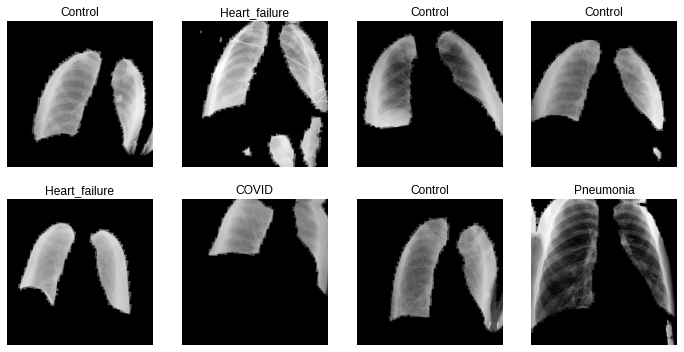

In [114]:
mixed_dls_0.show_batch()

In [108]:
global glb_tab_logits
def get_tab_logits(self, inp, out):
    global glb_tab_logits
    glb_tab_logits = inp
    #return None

global glb_vis_logits
def get_vis_logits(self, inp, out):
    global glb_vis_logits
    glb_vis_logits = inp
    #return None

In [109]:
class TabVis(nn.Module):
    def __init__(self, tab_model, vis_model, num_classes=4): 
        super(TabVis, self).__init__()
        self.tab_model = tab_model
        self.vis_model = vis_model
        
        #self.mixed_cls = nn.Linear(512+100, num_classes)
        self.mixed_cls = nn.Linear(512+4, num_classes)
        #self.tab_cls = nn.Linear(100, num_classes)
        self.tab_cls = nn.Linear(4, num_classes)
        self.vis_cls = nn.Linear(512, num_classes)
        
        #self.print_handle = self.tab_model.layers[2][0].register_forward_hook(printnorm)
        self.tab_handle = self.tab_model.tab_net.final_mapping.register_forward_hook(get_tab_logits)
        #self.tab_handle = self.tab_model.layers[2][0].register_forward_hook(get_tab_logits)
        self.vis_handle = self.vis_model[-1][-1].register_forward_hook(get_vis_logits)
    
    def remove_my_hooks(self):
        self.tab_handle.remove()
        self.vis_handle.remove()
        #self.print_handle.remove()
        return None
        
    def forward(self, x_cat, x_cont, x_im):
        # Tabular Classifier
        tab_pred = self.tab_model(x_cat, x_cont)        
        
        # Vision Classifier
        vis_pred = self.vis_model(x_im)
        
        # Logits
        tab_logits = glb_tab_logits[0]   # Only grabbling weights, not bias'
        vis_logits = glb_vis_logits[0]   # Only grabbling weights, not bias'
        mixed = torch.cat((tab_logits, vis_logits), dim=1)
        
        # Mixed Classifier
        mixed_pred = self.mixed_cls(mixed)
        return (tab_pred, vis_pred, mixed_pred)

In [110]:
def ModCELoss(pred, targ, weight=None, ce=True):
    pred = pred.softmax(dim=-1)
    targ = targ.flatten().long()
    if ce:
        loss = F.cross_entropy(pred, targ, weight=weight)
    else:
        loss = F.binary_cross_entropy_with_logits(pred, targ, weight=weight)
    #loss = torch.mean(ce)
    return loss

class myGradientBlending(nn.Module):
    def __init__(self, tab_weight=0.0, visual_weight=0.0, tab_vis_weight=1.0, loss_scale=1.0, weight=None, use_cel=True):
        "Expects weights for each model, the combined model, and an overall scale"
        super(myGradientBlending, self).__init__()
        self.tab_weight = tab_weight
        self.visual_weight = visual_weight
        self.tab_vis_weight = tab_vis_weight
        self.ce =  use_cel
        self.scale = loss_scale
        self.weight = weight
        
    def forward(self, xb, yb):
        tab_out, visual_out, tv_out = xb
        targ = yb
        "Gathers `self.loss` for each model, weighs, then sums"
        tv_loss = ModCELoss(tv_out, targ, self.weight, self.ce) * self.scale
        t_loss = ModCELoss(tab_out, targ, self.weight, self.ce) * self.scale
        v_loss = ModCELoss(visual_out, targ, self.weight, self.ce) * self.scale
        
        weighted_t_loss = t_loss * self.tab_weight
        weighted_v_loss = v_loss * self.visual_weight
        weighted_tv_loss = tv_loss * self.tab_vis_weight
        
        loss = weighted_t_loss + weighted_v_loss + weighted_tv_loss
        return loss

In [111]:
def t_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
#     print(inp[0])
#     print(inp[0].argmax(dim=axis))
#     print(targ)
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def v_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def tv_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[2].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def weighted_accuracy(inp, targ, axis=-1, w_t=0.333, w_v=0.333, w_tv=0.333):
    t_inp = inp[0] * w_t
    v_inp = inp[1] * w_v
    tv_inp = inp[2] * w_tv
    inp_fin = (t_inp + v_inp + tv_inp)/3
    pred,targ = flatten_check(inp_fin.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [114]:
# Set weights for each loss
tab_w = 0.8
vis_w = 0.73
tv_w = 0.3

In [113]:
# Get uni-modal models
v_model_0 = cnn_learner(vis_dl_0, resnet34, metrics=[accuracy], pretrained=True).model
v_model_0.load_state_dict(torch.load('models/vis_learn_0'))
#t_model_0 = tabular_learner(tab_dl_0, metrics=[accuracy]).model
t_model_0 = tabnet_learn_0.model
#t_model_0.load_state_dict(torch.load('models/tab_learn_0'))
t_model_0.load_state_dict(torch.load('models/tabnet_learn_0'))

# Create our Multi-Modal model
multi_model_0 = TabVis(t_model_0, v_model_0)

# Initialise Loss
gb_loss_0 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_0,
                             loss_scale=1.0, use_cel=True)

# Define accuracy weights
w_accuracy = partial(weighted_accuracy, w_t=tab_w, w_v=vis_w, w_tv=tv_w)

metrics = [t_accuracy ,v_accuracy, tv_accuracy, w_accuracy]

In [115]:
v_model_1 = cnn_learner(vis_dl_1, resnet34, metrics=[accuracy], pretrained=True).model
v_model_1.load_state_dict(torch.load('models/vis_learn_1'))
t_model_1 = tabnet_learn_1.model
t_model_1.load_state_dict(torch.load('models/tabnet_learn_1'))

v_model_2 = cnn_learner(vis_dl_2, resnet34, metrics=[accuracy], pretrained=True).model
v_model_2.load_state_dict(torch.load('models/vis_learn_2'))
t_model_2 = tabnet_learn_2.model
t_model_2.load_state_dict(torch.load('models/tabnet_learn_2'))

v_model_3 = cnn_learner(vis_dl_3, resnet34, metrics=[accuracy], pretrained=True).model
v_model_3.load_state_dict(torch.load('models/vis_learn_3'))
t_model_3 = tabnet_learn_3.model
t_model_3.load_state_dict(torch.load('models/tabnet_learn_3'))

v_model_4 = cnn_learner(vis_dl_4, resnet34, metrics=[accuracy], pretrained=True).model
v_model_4.load_state_dict(torch.load('models/vis_learn_4'))
t_model_4 = tabnet_learn_4.model
t_model_4.load_state_dict(torch.load('models/tabnet_learn_4'))

<All keys matched successfully>

In [116]:
multi_model_1 = TabVis(t_model_1, v_model_1)
multi_model_2 = TabVis(t_model_2, v_model_2)
multi_model_3 = TabVis(t_model_3, v_model_3)
multi_model_4 = TabVis(t_model_4, v_model_4)

In [117]:
gb_loss_0 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_0,
                             loss_scale=1.0, use_cel=True)
gb_loss_1 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_1,
                             loss_scale=1.0, use_cel=True)
gb_loss_2 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_2,
                             loss_scale=1.0, use_cel=True)
gb_loss_3 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_3,
                             loss_scale=1.0, use_cel=True)
gb_loss_4 = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, weight=class_weights_4,
                             loss_scale=1.0, use_cel=True)

In [118]:
multi_learn_0 = Learner(mixed_dls_0, multi_model_0, gb_loss_0, metrics=metrics)
multi_learn_1 = Learner(mixed_dls_1, multi_model_1, gb_loss_1, metrics=metrics)
multi_learn_2 = Learner(mixed_dls_2, multi_model_2, gb_loss_2, metrics=metrics)
multi_learn_3 = Learner(mixed_dls_3, multi_model_3, gb_loss_3, metrics=metrics)
multi_learn_4 = Learner(mixed_dls_4, multi_model_4, gb_loss_4, metrics=metrics)

In [156]:
multi_learn_0.fine_tune(100, freeze_epochs=100, #base_lr= 1e-3,
                      cbs=[EarlyStoppingCallback(monitor='tv_accuracy', patience=20), 
                           SaveModelCallback(monitor='tv_accuracy', with_opt=True, 
                                             fname='fastai2_TABNETVIS_0_beta')])

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.920650,1.891772,0.662612,0.786812,0.793854,0.793854,01:50
1,1.722615,1.886770,0.680538,0.769526,0.778489,0.777849,01:48
2,1.926744,1.890228,0.683739,0.775288,0.787452,0.779129,01:49
3,1.720530,1.888281,0.666453,0.778489,0.779129,0.782330,01:47
4,1.935416,1.884187,0.692061,0.777209,0.782971,0.779770,01:47
5,1.697007,1.898989,0.660691,0.774008,0.778489,0.777849,01:48
6,1.946165,1.914295,0.670935,0.758643,0.765045,0.763764,01:49
7,1.743134,1.904958,0.670295,0.761844,0.766965,0.765045,01:48
8,1.922981,1.885446,0.676056,0.774648,0.786812,0.782330,01:47
9,1.751813,1.891114,0.659411,0.784251,0.790013,0.786812,01:48


Better model found at epoch 0 with tv_accuracy value: 0.7938540577888489.
Better model found at epoch 12 with tv_accuracy value: 0.7989756464958191.
No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.703826,1.891657,0.661332,0.781050,0.787452,0.781690,01:46
1,1.920805,1.906271,0.644046,0.792574,0.793214,0.793214,01:47
2,1.710198,1.887625,0.667734,0.771447,0.784891,0.775288,01:46
3,1.918393,1.907633,0.666453,0.782330,0.786172,0.782330,01:47
4,1.671380,1.869507,0.690781,0.776568,0.787452,0.780410,01:46
5,1.903502,1.906582,0.669654,0.775288,0.776568,0.775928,01:47
6,1.687578,1.896018,0.647247,0.778489,0.790013,0.784891,01:48
7,1.916838,1.938771,0.594110,0.779129,0.781050,0.780410,01:47
8,1.696548,1.879182,0.662612,0.787452,0.797055,0.793214,01:47
9,1.913333,1.919559,0.677977,0.763764,0.767606,0.763764,01:47


Better model found at epoch 0 with tv_accuracy value: 0.787451982498169.
Better model found at epoch 1 with tv_accuracy value: 0.7932138442993164.
Better model found at epoch 8 with tv_accuracy value: 0.7970550656318665.
Better model found at epoch 14 with tv_accuracy value: 0.8021767139434814.
No improvement since epoch 14: early stopping


In [157]:
multi_learn_1.fine_tune(100, freeze_epochs=100, #base_lr= 1e-3,
                      cbs=[EarlyStoppingCallback(monitor='tv_accuracy', patience=20), 
                           SaveModelCallback(monitor='tv_accuracy', with_opt=True, 
                                             fname='fastai2_TABNETVIS_1_beta')])

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,2.077851,2.022807,0.642214,0.733591,0.702703,0.743243,01:46
1,2.227216,2.028598,0.640927,0.700129,0.694337,0.711068,01:45
2,2.053992,2.000492,0.637066,0.715573,0.707207,0.723295,01:46
3,2.185729,1.973989,0.649292,0.736808,0.727799,0.741956,01:47
4,2.002186,1.962322,0.657658,0.738095,0.729086,0.743887,01:47
5,2.158473,1.922082,0.660232,0.771557,0.765766,0.775418,01:46
6,1.978429,1.911588,0.653153,0.785071,0.784427,0.790862,01:46
7,2.148784,1.927369,0.655727,0.767696,0.763192,0.773488,01:46
8,1.945003,1.923499,0.659588,0.772201,0.771557,0.779279,01:46
9,2.140212,1.943429,0.658945,0.746461,0.750965,0.750322,01:47


Better model found at epoch 0 with tv_accuracy value: 0.7027027010917664.
Better model found at epoch 2 with tv_accuracy value: 0.707207202911377.
Better model found at epoch 3 with tv_accuracy value: 0.7277992367744446.
Better model found at epoch 4 with tv_accuracy value: 0.7290862202644348.
Better model found at epoch 5 with tv_accuracy value: 0.7657657861709595.
Better model found at epoch 6 with tv_accuracy value: 0.784427285194397.
Better model found at epoch 25 with tv_accuracy value: 0.7953668236732483.
Better model found at epoch 34 with tv_accuracy value: 0.799227774143219.
Better model found at epoch 47 with tv_accuracy value: 0.8120977878570557.
Better model found at epoch 48 with tv_accuracy value: 0.8146718144416809.
No improvement since epoch 48: early stopping


epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,2.117192,1.886342,0.669884,0.767053,0.782497,0.772844,01:47
1,1.866148,1.908821,0.636422,0.757400,0.773488,0.767053,01:49
2,2.131448,1.911406,0.674389,0.731660,0.749678,0.741956,01:47
3,1.881029,1.913033,0.633848,0.753539,0.774775,0.765122,01:46
4,2.079428,1.927742,0.646718,0.734878,0.749035,0.739382,01:48
5,1.857975,1.855983,0.678893,0.775418,0.796010,0.785071,01:47
6,2.135555,1.866090,0.682111,0.780566,0.789575,0.790862,01:47
7,1.856371,1.867136,0.677606,0.765766,0.785714,0.777992,01:47
8,2.093586,1.883180,0.687259,0.758044,0.759974,0.766409,01:47
9,1.892214,1.902932,0.674389,0.740026,0.769627,0.750965,01:47


Better model found at epoch 0 with tv_accuracy value: 0.7824968099594116.
Better model found at epoch 5 with tv_accuracy value: 0.7960103154182434.
Better model found at epoch 22 with tv_accuracy value: 0.7972972989082336.
No improvement since epoch 22: early stopping


In [158]:
multi_learn_2.fine_tune(100, freeze_epochs=100, #base_lr= 1e-3,
                      cbs=[EarlyStoppingCallback(monitor='tv_accuracy', patience=20), 
                           SaveModelCallback(monitor='tv_accuracy', with_opt=True, 
                                             fname='fastai2_TABNETVIS_2_beta')])

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.800392,1.899207,0.718033,0.771148,0.742951,0.780984,01:47
1,1.988808,1.860685,0.737049,0.790164,0.771803,0.798689,01:47
2,1.755308,1.868603,0.705574,0.771803,0.769180,0.789508,01:47
3,1.971423,1.877333,0.691148,0.784918,0.782295,0.792131,01:47
4,1.767602,1.856019,0.710820,0.786885,0.785574,0.798689,01:46
5,1.926413,1.862697,0.704262,0.791475,0.787541,0.797377,01:46
6,1.730369,1.863522,0.699672,0.790820,0.796066,0.796721,01:47
7,1.959459,1.851071,0.716066,0.787541,0.790164,0.795410,01:47
8,1.749345,1.842936,0.708197,0.803279,0.805902,0.810492,01:48
9,1.976492,1.852484,0.718033,0.783607,0.788852,0.788852,01:48


Better model found at epoch 0 with tv_accuracy value: 0.7429507970809937.
Better model found at epoch 1 with tv_accuracy value: 0.7718032598495483.
Better model found at epoch 3 with tv_accuracy value: 0.7822951078414917.
Better model found at epoch 4 with tv_accuracy value: 0.7855737805366516.
Better model found at epoch 5 with tv_accuracy value: 0.7875409722328186.
Better model found at epoch 6 with tv_accuracy value: 0.7960655689239502.
Better model found at epoch 8 with tv_accuracy value: 0.8059016466140747.
No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.946704,1.878733,0.709508,0.770492,0.769180,0.779672,01:47
1,1.740634,1.873286,0.689180,0.769836,0.775738,0.777705,01:46
2,1.935277,1.850505,0.710164,0.795410,0.798033,0.800000,01:46
3,1.721377,1.861655,0.683279,0.787541,0.792131,0.792787,01:47
4,1.922807,1.871575,0.693115,0.780328,0.783607,0.789508,01:47
5,1.705015,1.890159,0.671475,0.773115,0.776393,0.777705,01:47
6,1.943701,1.892275,0.687869,0.771803,0.776393,0.775738,01:47
7,1.749949,1.891081,0.666229,0.767213,0.775082,0.773771,01:48
8,1.960392,1.851186,0.731803,0.785574,0.788852,0.789508,01:47
9,1.735196,1.890565,0.664918,0.769836,0.771803,0.771148,01:47


Better model found at epoch 0 with tv_accuracy value: 0.7691803574562073.
Better model found at epoch 1 with tv_accuracy value: 0.7757377028465271.
Better model found at epoch 2 with tv_accuracy value: 0.7980327606201172.
No improvement since epoch 2: early stopping


In [159]:
multi_learn_3.fine_tune(100, freeze_epochs=100, #base_lr= 1e-3,
                      cbs=[EarlyStoppingCallback(monitor='tv_accuracy', patience=20), 
                           SaveModelCallback(monitor='tv_accuracy', with_opt=True, 
                                             fname='fastai2_TABNETVIS_3_beta')])

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.987100,1.900388,0.724456,0.791035,0.758734,0.794990,01:46
1,1.739128,1.876278,0.704680,0.789717,0.780488,0.796309,01:46
2,1.935843,1.866004,0.705339,0.794331,0.779169,0.801582,01:46
3,1.731695,1.854414,0.711931,0.799604,0.796968,0.805537,01:46
4,1.942057,1.850016,0.715227,0.803560,0.793012,0.811470,01:48
5,1.730496,1.854157,0.731707,0.796309,0.786421,0.801582,01:48
6,1.945834,1.840102,0.732367,0.798286,0.797627,0.802900,01:47
7,1.707079,1.838027,0.727752,0.805537,0.806196,0.810152,01:46
8,1.940202,1.839511,0.733685,0.806196,0.807515,0.809492,01:46
9,1.728597,1.840293,0.718523,0.804878,0.804219,0.808833,01:47


Better model found at epoch 0 with tv_accuracy value: 0.7587343454360962.
Better model found at epoch 1 with tv_accuracy value: 0.7804877758026123.
Better model found at epoch 3 with tv_accuracy value: 0.7969676852226257.
Better model found at epoch 6 with tv_accuracy value: 0.7976269125938416.
Better model found at epoch 7 with tv_accuracy value: 0.8061964511871338.
Better model found at epoch 8 with tv_accuracy value: 0.8075148463249207.
Better model found at epoch 17 with tv_accuracy value: 0.8127884268760681.
No improvement since epoch 17: early stopping


epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.949744,1.872953,0.649967,0.800923,0.804878,0.807515,01:46
1,1.707758,1.829679,0.720501,0.810152,0.816084,0.818721,01:46
2,1.909268,1.835147,0.737640,0.794331,0.799604,0.805537,01:47
3,1.706678,1.859848,0.692815,0.792353,0.797627,0.798945,01:48
4,1.927865,1.862528,0.694133,0.794990,0.800264,0.798945,01:48
5,1.695868,1.848758,0.692815,0.797627,0.806856,0.804878,01:47
6,1.955158,1.887083,0.684904,0.775214,0.781147,0.781147,01:48
7,1.721131,1.880083,0.650626,0.789057,0.793012,0.796968,01:47
8,1.933740,1.862492,0.707317,0.796968,0.798286,0.800264,01:48
9,1.739347,1.830392,0.715887,0.803560,0.805537,0.804878,01:48


Better model found at epoch 0 with tv_accuracy value: 0.8048780560493469.
Better model found at epoch 1 with tv_accuracy value: 0.8160843849182129.
No improvement since epoch 1: early stopping


In [160]:
multi_learn_4.fine_tune(100, freeze_epochs=100, #base_lr= 1e-3,
                      cbs=[EarlyStoppingCallback(monitor='tv_accuracy', patience=20), 
                           SaveModelCallback(monitor='tv_accuracy', with_opt=True, 
                                             fname='fastai2_TABNETVIS_4_beta')])

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.778162,1.900567,0.655446,0.794059,0.790099,0.807261,01:47
1,1.979098,1.888814,0.667327,0.793399,0.788119,0.802640,01:48
2,1.715503,1.866576,0.658086,0.811881,0.813861,0.821122,01:48
3,1.950486,1.870880,0.661386,0.804620,0.804620,0.807921,01:47
4,1.740600,1.856758,0.685809,0.803960,0.805941,0.809241,01:49
5,1.947971,1.858095,0.677888,0.802640,0.810561,0.809241,01:48
6,1.712881,1.844675,0.697030,0.805941,0.809241,0.813201,01:48
7,1.961532,1.845965,0.695050,0.809901,0.814521,0.814521,01:48
8,1.701469,1.842680,0.693069,0.810561,0.814521,0.815181,01:48
9,1.951066,1.855233,0.681188,0.807921,0.815181,0.813201,01:48


Better model found at epoch 0 with tv_accuracy value: 0.790099024772644.
Better model found at epoch 2 with tv_accuracy value: 0.8138613700866699.
Better model found at epoch 7 with tv_accuracy value: 0.8145214319229126.
Better model found at epoch 9 with tv_accuracy value: 0.8151814937591553.
Better model found at epoch 18 with tv_accuracy value: 0.8231022953987122.
No improvement since epoch 18: early stopping


epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,1.920901,1.861781,0.671947,0.797360,0.805941,0.803300,01:48
1,1.721939,1.850356,0.683828,0.801320,0.811221,0.808581,01:47
2,1.932976,1.859509,0.685809,0.801980,0.808581,0.805281,01:48
3,1.703880,1.853900,0.681188,0.798020,0.810561,0.808581,01:48
4,1.924286,1.848695,0.706931,0.801980,0.805281,0.807261,01:48
5,1.702224,1.852609,0.691089,0.798680,0.803300,0.799340,01:47
6,1.949107,1.846650,0.700330,0.791419,0.799340,0.796700,01:49
7,1.705726,1.847282,0.669967,0.813861,0.818482,0.816502,01:48
8,1.939326,1.857686,0.691749,0.794719,0.803300,0.803300,01:49
9,1.710313,1.874157,0.642904,0.795380,0.804620,0.800000,01:49


Better model found at epoch 0 with tv_accuracy value: 0.805940568447113.
Better model found at epoch 1 with tv_accuracy value: 0.8112211227416992.
Better model found at epoch 7 with tv_accuracy value: 0.8184818625450134.
No improvement since epoch 7: early stopping


## FIN